# Feedback control

WOW ARE WE GOING TO DO CONTROL NOW??? *FINALLY*???? Yes! No... There's one more difference we need to explain. There are two types of feedback control, output and state feedback. The difference is in the name and here you also see the difference in a block diagram for a plant/process/system, $P$, and a controller, $C$.

![output vs state feedback](../figures/xyFB.svg)

Output feedback is stuff like PID, or in other terms: disgusting. We'll look at state feedback now! *The real stuff.*

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

import scipy.signal as signal
import scipy.linalg as sclin
import numpy.random as rng
import numpy.linalg as lin
import control as cm
from helperFunctions import *
setPlotStyle()


<IPython.core.display.Javascript object>

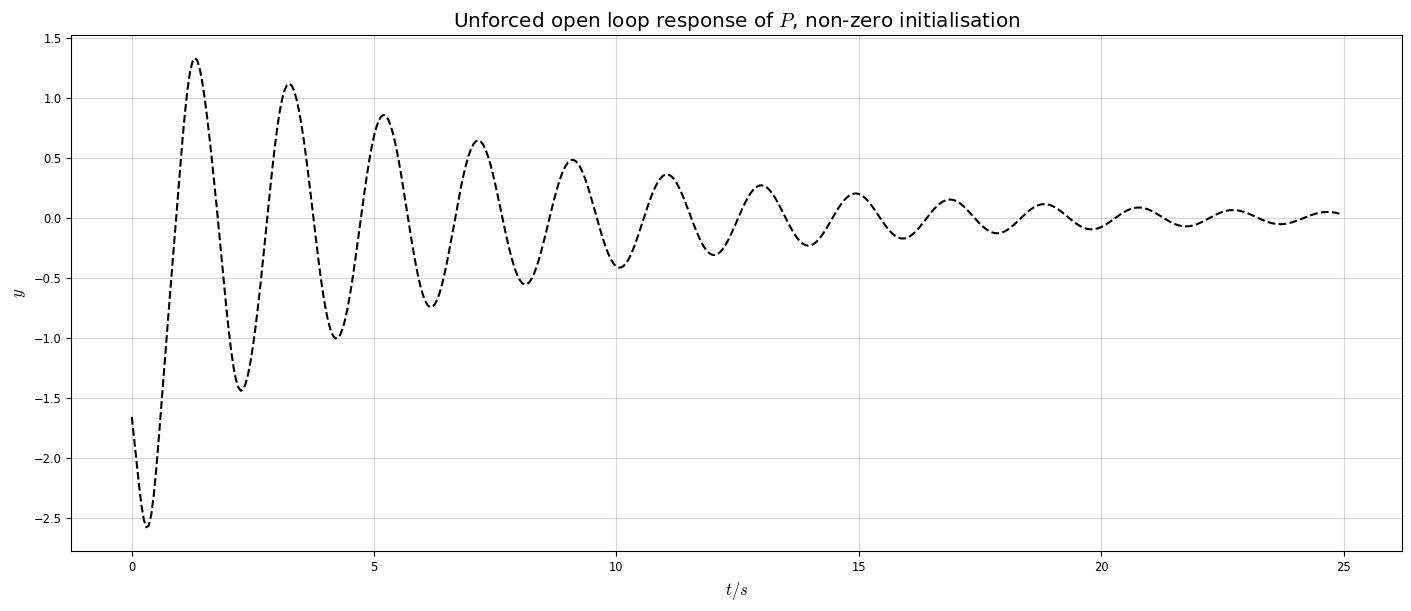

In [4]:
P_reg = cm.ss(cm.zpk(zeros=[-3], 
                     poles=cm.rss(5).poles(), 
                     gain=1, dt=0))
nx_reg = len(P_reg.poles())
x0_reg = rng.randn(nx_reg,1)

T_reg = np.arange(500)*0.05
unforced_reg = cm.forced_response(sysdata=P_reg, 
                              T=T_reg, 
                              X0=x0_reg)

####### Plotting #######
fig, ax = plt.subplots()
ax.plot(unforced_reg.time, unforced_reg.outputs, 'k--')
ax.set(title="Unforced open loop response of $P$, non-zero initialisation", xlabel="$t/s$", ylabel="$y$")
display(fig)


We can choose the controller $C: u = -Kx$, and for reachable systems, we can always find a $K$ such that the closed loop system has poles at freely chosen locations. What does that closed loop system look like? Substituting the controller into the state dynamics yields
$$ \dot x = Ax + Bu = Ax - BKx = (A-BK) x.$$
So the closed loop system poles are the eigenvalues of $(A-BK)$. If we choose the poles to have a negative real part, the closed loop is stable and the output will go to zero. This type of controller that steers to zero is called a regulator.

<IPython.core.display.Javascript object>

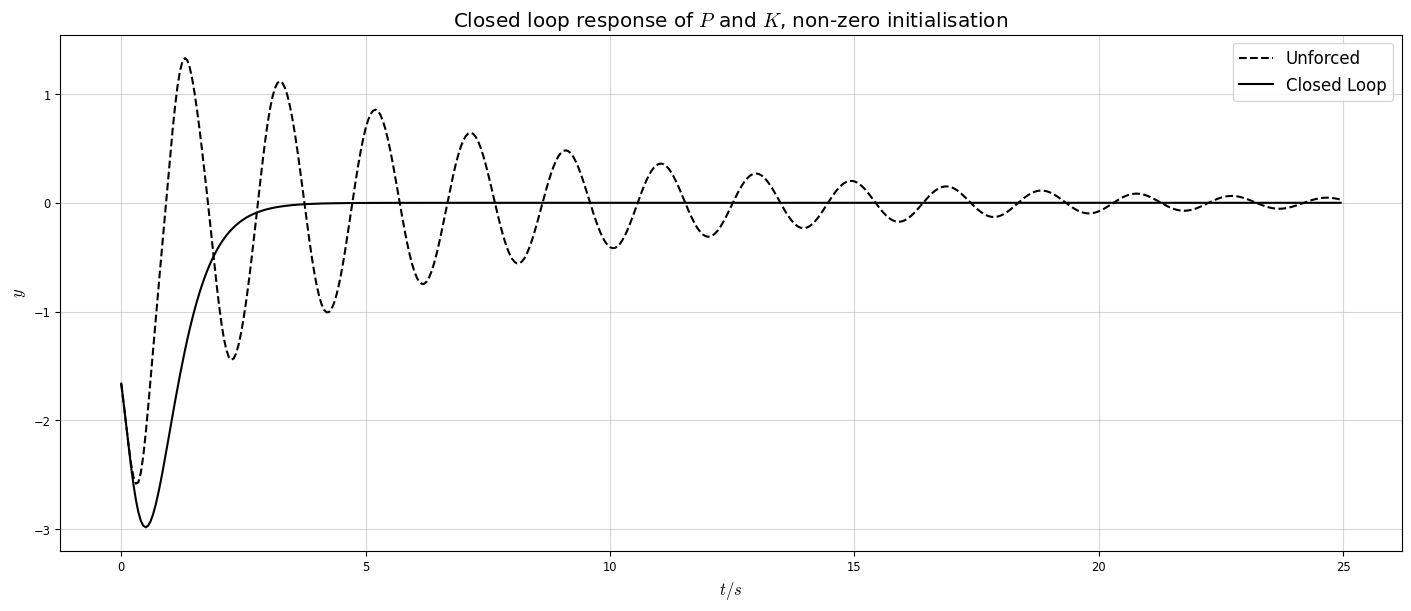

In [5]:
## Check controllability!
def isControlable(A, B):
    Wr = cm.ctrb(A, B)
    return lin.matrix_rank(Wr) == A.shape[0]

assert isControlable(P_reg.A, P_reg.B)==True, "System is uncontrollable D:"

CLpoles_reg = np.linspace(-2, -6, nx_reg)
K_reg = cm.place(P_reg.A, P_reg.B, CLpoles_reg)
CL_reg = cm.ss(P_reg.A-P_reg.B@K_reg, 
                np.zeros([nx_reg,1]), 
                P_reg.C, 
                P_reg.D)

forced_reg = cm.forced_response(sysdata=CL_reg, 
                                T=T_reg, 
                                X0=x0_reg)

####### Plotting #######
fig, ax = plt.subplots()
ax.plot(unforced_reg.time, unforced_reg.outputs, 'k--', label="Unforced")
ax.plot(forced_reg.time, forced_reg.outputs, 'k', label="Closed Loop")
ax.legend()
ax.set(title="Closed loop response of $P$ and $K$, non-zero initialisation", xlabel="$t/s$", ylabel="$y$")
display(fig)


However, regulating to zero is boring, I want to be able to tell my system to do a backflip! We need to add a reference, and I'll spoil that we also need a reference gain $k_f$:

![Reference tracking](../figures/refTrackCL.svg)

So how does this work then... Same substitution as before!
$$ \dot x = Ax + Bu = Ax + B(k_f r - Kx) = (A-BK) x + Bk_f r.$$
Now to determine $k_f$, we want to prevent steady state errors, so $\bar y = r$. Steady state also means
$$ \dot x = 0 = (A-BK) \bar x + Bk_f r \rightarrow \bar x = -(A-BK)^{-1}Bk_f r.$$
Now assuming $D=0$ to make things easier, substituting and rewriting gives
$$\bar y = r \rightarrow C\bar x + \underbrace{D}_{=0}\bar u = C\bar x = r$$
$$\rightarrow -C(A-BK)^{-1}Bk_f r = r \rightarrow k_f = \frac{-1}{C(A-BK)^{-1}B}.$$



<IPython.core.display.Javascript object>

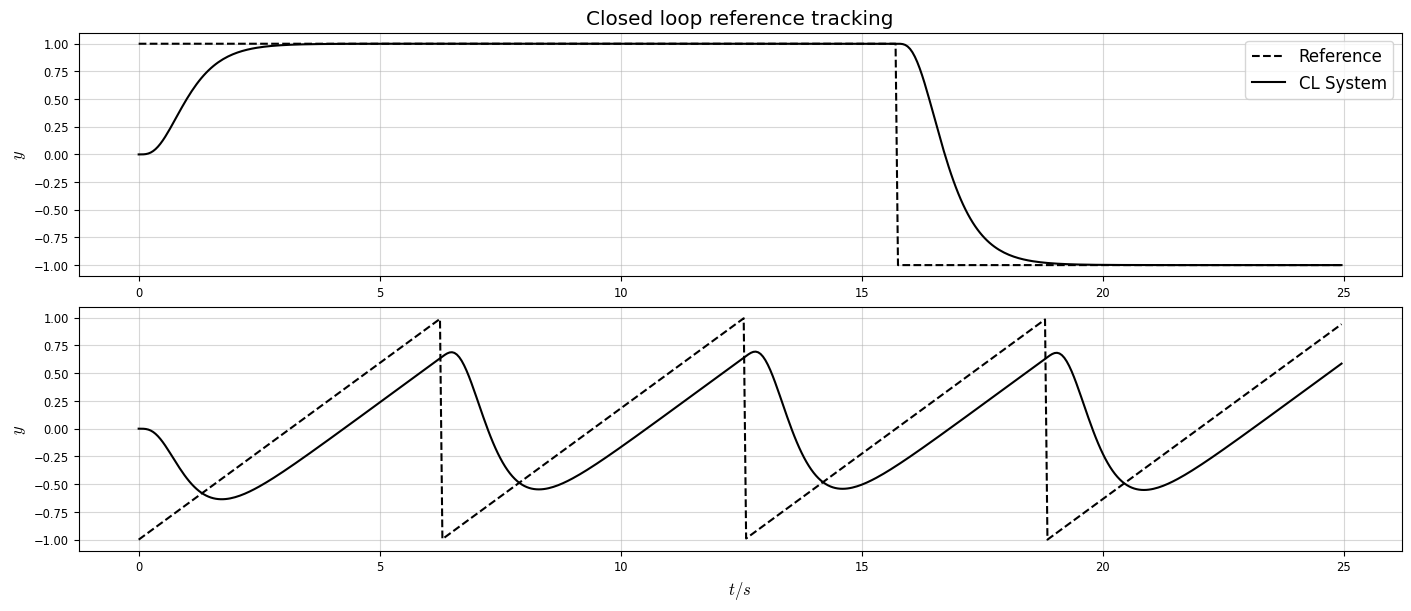

In [6]:
kf_ref = (-1/(P_reg.C@lin.inv(P_reg.A - P_reg.B@K_reg)@P_reg.B))[0,0]

CL_ref = cm.ss(P_reg.A-P_reg.B@K_reg, 
               P_reg.B*kf_ref, 
               P_reg.C, 
               P_reg.D)
sqr_ref = signal.square(t=T_reg*0.2)
saw_ref = signal.sawtooth(t=T_reg)

response_sqr_ref = cm.forced_response(sysdata=CL_ref, T=T_reg, U=sqr_ref)
response_saw_ref = cm.forced_response(sysdata=CL_ref, T=T_reg, U=saw_ref)

fig, ax = plt.subplots(2,1)
ax[0].plot(response_sqr_ref.time, response_sqr_ref.inputs , 'k--', label="Reference")
ax[0].plot(response_sqr_ref.time, response_sqr_ref.outputs, 'k', label="CL System")
ax[1].plot(response_saw_ref.time, response_saw_ref.inputs , 'k--', label="Reference")
ax[1].plot(response_saw_ref.time, response_saw_ref.outputs, 'k', label="CL System")
ax[0].legend()
ax[0].set(title="Closed loop reference tracking", ylabel="$y$")
ax[1].set(xlabel="$t/s$", ylabel="$y$")
display(fig)
